## Imports

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
pio.renderers.default = 'notebook_connected'

##  Data QC & preprocessing

In [2]:
phenotypes = pd.read_csv('phenotypes.tsv.gz', sep='\t', compression='gzip')

In [75]:
phenotypes.shape

(1364, 12)

In [76]:
phenotypes

,#sample_id,pancreas_cancer,age,ancestry,smoking_history,bmi,sex,PC1,PC2,PC3,PC4,PC5
0,BGC_000034,0,48.0,EUR,0.0,27.8,1,-0.0120,0.0174,0.0085,-0.0179,0.0003
1,BGC_000052,0,44.0,EUR,0.0,30.4,1,-0.0096,0.0236,0.0120,-0.0197,-0.0033
2,BGC_000069,0,48.0,EAS,0.0,27.5,2,-0.0128,-0.0294,0.0047,-0.0055,-0.0014
3,BGC_000071,0,62.0,EUR,0.0,25.7,2,-0.0108,0.0191,0.0053,-0.0148,-0.0008
4,BGC_000083,0,45.0,EUR,0.0,30.5,1,-0.0110,0.0223,0.0112,-0.0130,-0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...
1359,PCiYP00991,1,37.0,AMR,2.0,25.0,2,-0.0099,0.0110,0.0167,0.0061,0.0005
1360,PCiYP00993,1,44.0,SAS,0.0,28.2,2,-0.0105,0.0014,-0.0332,0.0165,0.0003
1361,PCiYP00994,1,46.0,EAS,0.0,29.9,2,-0.0121,-0.0343,0.0020,-0.0149,-0.0009
1362,PCiYP00995,1,41.0,EUR,0.0,21.5,2,-0.0108,0.0206,0.0055,-0.0138,-0.0013


In [77]:
phenotypes.columns

Index(['#sample_id', 'pancreas_cancer', 'age', 'ancestry', 'smoking_history',
       'bmi', 'sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
      dtype='object')

In [78]:
phenotypes['pancreas_cancer'].value_counts()

pancreas_cancer
0    891
1    473
Name: count, dtype: int64

In [79]:
phenotypes['ancestry'].value_counts()
phenotypes['sex'].value_counts()

sex
2    691
1    673
Name: count, dtype: int64

In [80]:
phenotypes.describe()

,pancreas_cancer,age,smoking_history,bmi,sex,PC1,PC2,PC3,PC4,PC5
count,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000
mean,0.346774,46.582111,0.247067,28.243548,1.506598,-0.000177,0.003256,0.000308,-0.004517,-0.000438
std,0.476118,5.790536,0.600647,2.238277,0.500140,0.017672,0.018233,0.014766,0.014474,0.016581
min,0.000000,26.000000,0.000000,21.400000,1.000000,-0.013600,-0.036200,-0.044300,-0.025800,-0.052900
25%,0.000000,43.000000,0.000000,26.900000,1.000000,-0.011600,-0.002200,-0.001100,-0.015500,-0.001600
50%,0.000000,46.000000,0.000000,28.200000,2.000000,-0.010800,0.003700,0.002600,-0.007950,-0.000200
75%,1.000000,50.000000,0.000000,29.700000,2.000000,0.025000,0.020500,0.008700,0.001425,0.001000
max,1.000000,66.000000,2.000000,36.900000,2.000000,0.032600,0.026600,0.046600,0.073600,0.075300


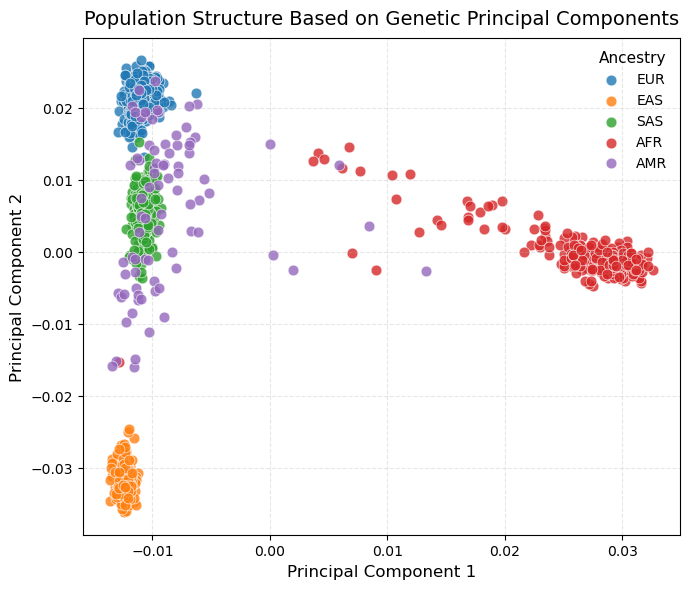

In [116]:
plt.figure(figsize=(7, 6))

colors = {'EUR': '#1f77b4', 'EAS': '#ff7f0e', 'SAS': '#2ca02c', 'AFR': '#d62728','AMR': '#9467bd'}

for anc in phenotypes['ancestry'].unique():
    subset = phenotypes[phenotypes['ancestry'] == anc]
    plt.scatter(subset['PC1'], subset['PC2'],
                color=colors[anc], label=anc, alpha=0.8, s=60, edgecolor='white', linewidth=0.5)

plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('Population Structure Based on Genetic Principal Components', fontsize=14, pad=10)
plt.legend(title='Ancestry', frameon=False, fontsize=10, title_fontsize=11, loc='best')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

##### PCA was done to visualize genetic population structure and check for ancestry-related differences in the samples. The first two components (PC1 and PC2) explain most of the genetic variation. Each dot represents one individual, colored by ancestry. The plot shows distinct clusters for European, East Asian, South Asian, African, and admixed (AMR) populations. This confirms that ancestry differences exist in the dataset, so the first five PCs (PC1–PC5) were included as covariates in the logistic regression model to adjust for population stratification and avoid false associations.

### Missing values

In [7]:
phenotypes.isna().sum()

#sample_id           0
pancreas_cancer      0
age                 28
ancestry             0
smoking_history    219
bmi                 69
sex                  0
PC1                  0
PC2                  0
PC3                  0
PC4                  0
PC5                  0
dtype: int64

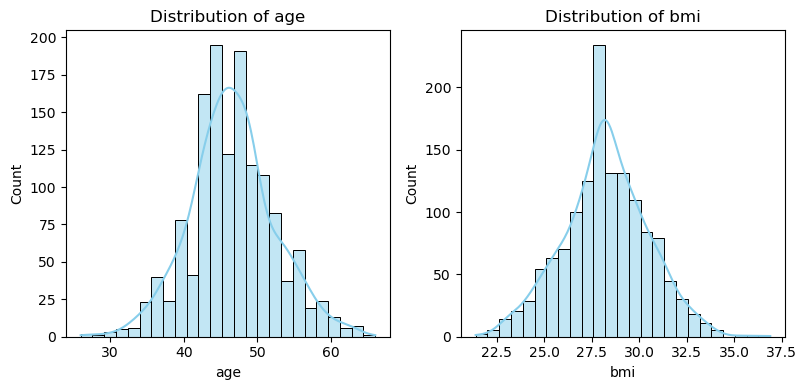

In [91]:
continuous_vars = ['age', 'bmi']

plt.figure(figsize=(12, 4))
for i, col in enumerate(continuous_vars):
    plt.subplot(1, 3, i+1)
    sns.histplot(phenotypes[col], kde=True, bins=25, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

##### Age, BMI, Smoking History have missing values. The distribution of Age and bmi are approximately normal. The proportion of missing data is small, so median/mode imputation preserves the distribution without introducing bias. If a huge percentage of data were missing, more complex multiple imputation would have been used. For patients with smoking history, the NANs were made to 0. If a larger proportion of data were missing, I would intorduce another "unknown" category.

In [8]:
phenotypes['age'] = phenotypes['age'].fillna(phenotypes['age'].median())
phenotypes['bmi'] = phenotypes['bmi'].fillna(phenotypes['bmi'].median())
phenotypes['smoking_history'] = phenotypes['smoking_history'].fillna(0)
phenotypes.isna().sum()

#sample_id         0
pancreas_cancer    0
age                0
ancestry           0
smoking_history    0
bmi                0
sex                0
PC1                0
PC2                0
PC3                0
PC4                0
PC5                0
dtype: int64

### Outlier detection

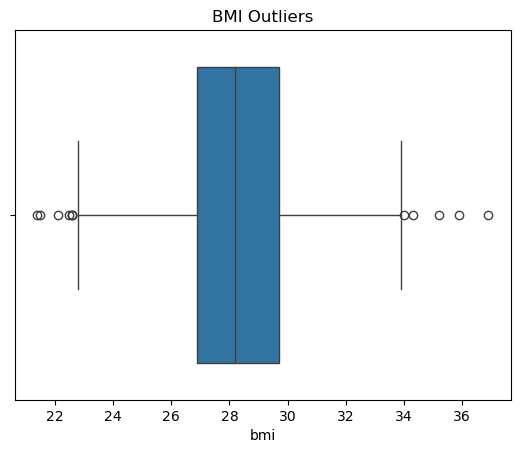

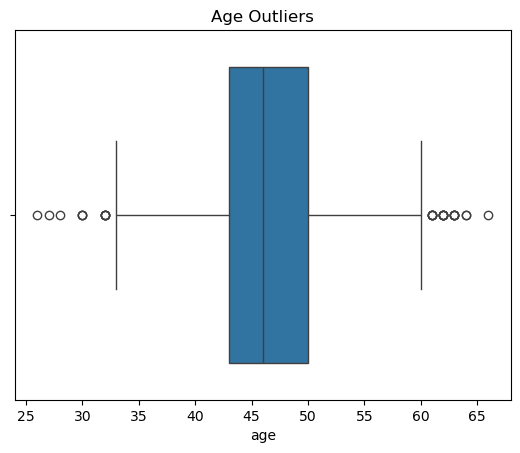

In [9]:
sns.boxplot(x=phenotypes['bmi'])
plt.title('BMI Outliers')
plt.show()

sns.boxplot(x=phenotypes['age'])
plt.title('Age Outliers')
plt.show()

##### Boxplots were used to identify potential outliers in continous numeric variables (BMI and Age). Mild outliers in case of BMI and age were retained, as they fall within plausible biological ranges and logistic regression is robust to moderate deviations.

### Genotype data QC

In [93]:
genotypes = pd.read_csv('candidate_EOPC_variants.allele_counts.tsv.gz', sep='\t', compression='gzip')

In [94]:
genotypes

,#variant,BGC_000034,BGC_000052,BGC_000069,BGC_000071,BGC_000083,BGC_000086,BGC_000091,BGC_000113,BGC_000150,...,PCiYP00984,PCiYP00986,PCiYP00988,PCiYP00989,PCiYP00990,PCiYP00991,PCiYP00993,PCiYP00994,PCiYP00995,PCiYP00999
0,chr18_15051_A_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr18_52006_G_T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr18_54257_A_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr18_86571_A_G,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0,...,2.0,2.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0
4,chr18_111667_C_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3359,chr18_80133824_CGTT_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3360,chr18_80210807_A_T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3361,chr18_80235608_G_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3362,chr18_80238502_A_AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
genotypes.columns

Index(['#variant', 'BGC_000034', 'BGC_000052', 'BGC_000069', 'BGC_000071',
       'BGC_000083', 'BGC_000086', 'BGC_000091', 'BGC_000113', 'BGC_000150',
       ...
       'PCiYP00984', 'PCiYP00986', 'PCiYP00988', 'PCiYP00989', 'PCiYP00990',
       'PCiYP00991', 'PCiYP00993', 'PCiYP00994', 'PCiYP00995', 'PCiYP00999'],
      dtype='object', length=1365)

### Missing rate 

In [96]:
genotypes.isna().sum()

#variant       0
BGC_000034    40
BGC_000052    42
BGC_000069    68
BGC_000071    45
              ..
PCiYP00991    32
PCiYP00993    46
PCiYP00994    36
PCiYP00995    42
PCiYP00999    37
Length: 1365, dtype: int64

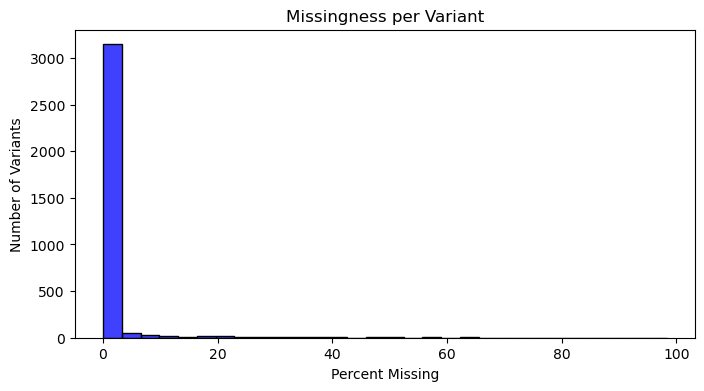

In [115]:
# %missing per variant 
variant_missing = genotypes.isna().mean(axis=1) * 100
# % missing per sample 
sample_missing = genotypes.isna().mean() * 100
plt.figure(figsize=(8,4))
sns.histplot(variant_missing, bins=30, color='blue')
plt.title('Missingness per Variant')
plt.xlabel('Percent Missing')
plt.ylabel('Number of Variants')
plt.show()

In [98]:
total = len(variant_missing)
over5 = (variant_missing > 5).sum()
over10 = (variant_missing > 10).sum()

print(f"Total variants: {total}")
print(f"Variants >5% missing: {over5} ({over5/total*100:.2f}%)")
print(f"Variants >10% missing: {over10} ({over10/total*100:.2f}%)")

Total variants: 3364
Variants >5% missing: 186 (5.53%)
Variants >10% missing: 134 (3.98%)


In [101]:
good_variants = variant_missing[variant_missing <= 5].index
genotypes_filtered = genotypes.loc[good_variants]
genotypes_filtered.shape

(3178, 1365)

 ##### The proportion of missing values was calculated using isna().mean(), which converts True/False to 1/0 and computes the average missing rate. axis=1 gives missingness per variant, row-wise, axis=0 gives missingness per sample, column-wise.To ensure reliable variant calls, per-variant missingness was calculated as the percentage of samples with missing genotypes. Variants with >5% missing data were excluded, as they are more likely to be poor quality loci.After filtering, 3,178 high-quality variants were retained.

### Rare variants 

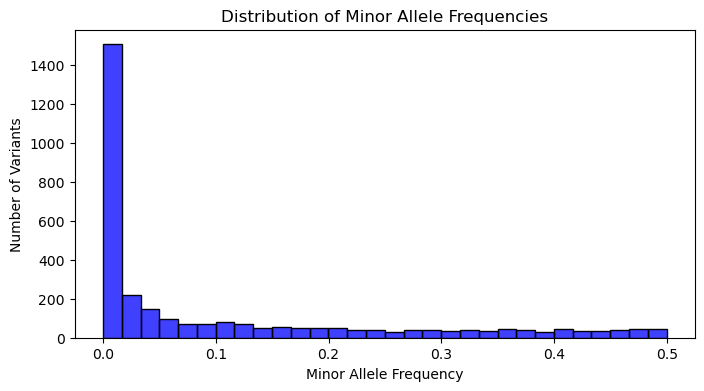

In [102]:
# MAF
geno_matrix = genotypes_filtered.iloc[:, 1:]  
allele_freq = geno_matrix.mean(axis=1) / 2
maf = np.minimum(allele_freq, 1 - allele_freq)

plt.figure(figsize=(8,4))
sns.histplot(maf, bins=30, color='blue')
plt.title('Distribution of Minor Allele Frequencies')
plt.xlabel('Minor Allele Frequency')
plt.ylabel('Number of Variants')
plt.show()

In [19]:
total = len(maf)
rare_1 = (maf < 0.01).sum()
rare_5 = (maf < 0.05).sum()
common = (maf >= 0.05).sum()


print(f"Total variants: {total}")
print(f"Rare (<1%): {rare_1} ({rare_1/total*100:.2f}%)")
print(f"Low frequency (1–5%): {rare_5 - rare_1} ({(rare_5 - rare_1)/total*100:.2f}%)")
print(f"Common (>5%): {common} ({common/total*100:.2f}%)")

Total variants: 3178
Rare (<1%): 1341 (42.20%)
Low frequency (1–5%): 532 (16.74%)
Common (>5%): 1305 (41.06%)


In [103]:
maf_threshold = 0.01
genotypes_final = genotypes_filtered.loc[maf[maf >= maf_threshold].index]

print(f"\nVariants kept after MAF ≥ 1% filter: {len(genotypes_final)} of {total} "
      f"({len(genotypes_final)/total*100:.2f}%)")


Variants kept after MAF ≥ 1% filter: 1837 of 3364 (54.61%)


##### The minor allele frequency (MAF) was calculated for all variants after missingness filtering. Variants with MAF < 1% were excluded, as extremely rare alleles can cause unstable logistic regression estimates and inflated p-values. After filtering, 1,837 variants - 57.8% with MAF ≥ 1% were retained for association analysis.

##### HWE Hardy–Weinberg Equilibrium Filtering testing is commonly applied in genome-wide association studies to identify variants with unexpected genotype proportions, often indicative of genotyping errors. Because this dataset comprises a small, preselected set of 3,364 high-confidence variants from a CRISPR-based screen with low missingness and good data quality HWE filtering was not applied. 

### merge on Genotype and Phenotype data

##### Both datasets were merged on the shared "sample_id" field to create a unified analysis table. This allows for logistic regression modeling, where disease status "pancreas_cancer" is the outcome, and each genetic variant (plus covariates: age, sex, BMI, ancestry PCs) serves as a predictor. 

In [105]:
# transpose
genotypes_t = genotypes_final.set_index('#variant').T

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [106]:
genotypes_t

#variant,chr18_15051_A_G,chr18_86571_A_G,chr18_111667_C_A,chr18_154192_G_A,chr18_214106_CAGTT_C,chr18_236019_A_G,chr18_309921_T_C,chr18_315232_TCA_T,chr18_331827_C_T,chr18_333739_A_G,...,chr18_79954138_G_A,chr18_79957497_C_CT,chr18_80005850_T_C,chr18_80040239_A_ATTTTTT,chr18_80043307_A_G,chr18_80062261_G_GT,chr18_80065055_C_T,chr18_80096657_A_G,chr18_80210807_A_T,chr18_80235608_G_A
BGC_000034,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
BGC_000052,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
BGC_000069,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
BGC_000071,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
BGC_000083,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCiYP00991,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
PCiYP00993,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
PCiYP00994,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
PCiYP00995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0


In [107]:
genotypes_t.reset_index(inplace=True)
genotypes_t.rename(columns={'index': '#sample_id'}, inplace=True)

In [108]:
phenotypes['#sample_id'] = phenotypes['#sample_id'].astype(str)
genotypes_t['#sample_id'] = genotypes_t['#sample_id'].astype(str)

In [109]:
merged = pd.merge(phenotypes, genotypes_t, on='#sample_id')
print(merged.shape)

(1364, 1849)


In [110]:
genotypes_t

#variant,#sample_id,chr18_15051_A_G,chr18_86571_A_G,chr18_111667_C_A,chr18_154192_G_A,chr18_214106_CAGTT_C,chr18_236019_A_G,chr18_309921_T_C,chr18_315232_TCA_T,chr18_331827_C_T,...,chr18_79954138_G_A,chr18_79957497_C_CT,chr18_80005850_T_C,chr18_80040239_A_ATTTTTT,chr18_80043307_A_G,chr18_80062261_G_GT,chr18_80065055_C_T,chr18_80096657_A_G,chr18_80210807_A_T,chr18_80235608_G_A
0,BGC_000034,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,BGC_000052,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,BGC_000069,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,BGC_000071,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,BGC_000083,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,PCiYP00991,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1360,PCiYP00993,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
1361,PCiYP00994,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1362,PCiYP00995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0


In [111]:
merged

,#sample_id,pancreas_cancer,age,ancestry,smoking_history,bmi,sex,PC1,PC2,PC3,...,chr18_79954138_G_A,chr18_79957497_C_CT,chr18_80005850_T_C,chr18_80040239_A_ATTTTTT,chr18_80043307_A_G,chr18_80062261_G_GT,chr18_80065055_C_T,chr18_80096657_A_G,chr18_80210807_A_T,chr18_80235608_G_A
0,BGC_000034,0,48.0,EUR,0.0,27.8,1,-0.0120,0.0174,0.0085,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,BGC_000052,0,44.0,EUR,0.0,30.4,1,-0.0096,0.0236,0.0120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,BGC_000069,0,48.0,EAS,0.0,27.5,2,-0.0128,-0.0294,0.0047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,BGC_000071,0,62.0,EUR,0.0,25.7,2,-0.0108,0.0191,0.0053,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,BGC_000083,0,45.0,EUR,0.0,30.5,1,-0.0110,0.0223,0.0112,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,PCiYP00991,1,37.0,AMR,2.0,25.0,2,-0.0099,0.0110,0.0167,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1360,PCiYP00993,1,44.0,SAS,0.0,28.2,2,-0.0105,0.0014,-0.0332,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
1361,PCiYP00994,1,46.0,EAS,0.0,29.9,2,-0.0121,-0.0343,0.0020,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1362,PCiYP00995,1,41.0,EUR,0.0,21.5,2,-0.0108,0.0206,0.0055,...,1.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0


## Association analysis

In [112]:
merged.dtypes

#sample_id              object
pancreas_cancer          int64
age                    float64
ancestry                object
smoking_history        float64
                        ...   
chr18_80062261_G_GT    float64
chr18_80065055_C_T     float64
chr18_80096657_A_G     float64
chr18_80210807_A_T     float64
chr18_80235608_G_A     float64
Length: 1849, dtype: object

In [113]:
# one hot encoding
merged = pd.get_dummies(merged, columns=['ancestry'], drop_first=True)

In [30]:
merged['sex'] = merged['sex'].map({1:0, 2:1})
ancestry_cols = [col for col in merged.columns if col.startswith('ancestry_')]

In [31]:
merged 

,#sample_id,pancreas_cancer,age,smoking_history,bmi,sex,PC1,PC2,PC3,PC4,...,chr18_80043307_A_G,chr18_80062261_G_GT,chr18_80065055_C_T,chr18_80096657_A_G,chr18_80210807_A_T,chr18_80235608_G_A,ancestry_AMR,ancestry_EAS,ancestry_EUR,ancestry_SAS
0,BGC_000034,0,48.0,0.0,27.8,0,-0.0120,0.0174,0.0085,-0.0179,...,0.0,0.0,1.0,1.0,0.0,0.0,False,False,True,False
1,BGC_000052,0,44.0,0.0,30.4,0,-0.0096,0.0236,0.0120,-0.0197,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,True,False
2,BGC_000069,0,48.0,0.0,27.5,1,-0.0128,-0.0294,0.0047,-0.0055,...,0.0,0.0,0.0,2.0,0.0,0.0,False,True,False,False
3,BGC_000071,0,62.0,0.0,25.7,1,-0.0108,0.0191,0.0053,-0.0148,...,0.0,0.0,1.0,1.0,0.0,0.0,False,False,True,False
4,BGC_000083,0,45.0,0.0,30.5,0,-0.0110,0.0223,0.0112,-0.0130,...,0.0,0.0,2.0,0.0,0.0,0.0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,PCiYP00991,1,37.0,2.0,25.0,1,-0.0099,0.0110,0.0167,0.0061,...,1.0,1.0,0.0,1.0,0.0,0.0,True,False,False,False
1360,PCiYP00993,1,44.0,0.0,28.2,1,-0.0105,0.0014,-0.0332,0.0165,...,0.0,0.0,1.0,2.0,0.0,0.0,False,False,False,True
1361,PCiYP00994,1,46.0,0.0,29.9,1,-0.0121,-0.0343,0.0020,-0.0149,...,0.0,0.0,0.0,2.0,0.0,0.0,False,True,False,False
1362,PCiYP00995,1,41.0,0.0,21.5,1,-0.0108,0.0206,0.0055,-0.0138,...,1.0,1.0,2.0,0.0,0.0,0.0,False,False,True,False


##### Encoding was done for Acestry, new columns added were: Ancestry_AMR, ancestry_EAS, ancestry_EUR, ancestry_SAS. The variable "sex" was originally coded as 1 = male and 2 = female. To include it as a binary covariate in regression models, it was re-encoded 

### Logistic Regression 

In [32]:
y = merged['pancreas_cancer'].astype(int)
covariates = ['age', 'sex', 'bmi', 'smoking_history', 
              'PC1', 'PC2', 'PC3', 'PC4', 'PC5'] + ancestry_cols
# covariate matrix
X_cov = sm.add_constant(merged[covariates])
variant_cols = [col for col in merged.columns if col.startswith('chr18_')]

In [34]:
results = []
failed_var = 0

for variant in variant_cols:
    try:
        #covariates + variant
        X = pd.concat([X_cov, merged[variant]], axis=1)
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        #convert to NumPy arrays
        X_np = np.asarray(X, dtype=float)
        y_np = np.asarray(y, dtype=float)

        #model
        model = sm.Logit(y_np, X_np)
        res = model.fit(disp = False)

        #beta, odds ratio and p value 
        beta = res.params[-1]
        pval = res.pvalues[-1]
        odds = np.exp(beta)
        results.append({'variant': variant, 
                        'beta': beta, 
                        'Odds Ratio': odds, 
                        'p value': pval})

    except Exception:
        failed_var += 1
        continue

print(f"Variants run: {len(results)}")
print(f"Skipped variants:{failed_var}")

results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df.sort_values('p value', inplace=True)
    results_df.to_csv('EOPC_logistic_results.tsv', sep='\t', index=False)
    print("\nTop 10 variants:")
    print(results_df.head(10))
else:
    print("No valid results")
    

if not results_df.empty:
    results_df['p_adj'] = multipletests(results_df['p value'], method='fdr_bh')[1]
    results_df.to_csv('EOPC.tsv', sep='\t', index=False)

Variants run: 1617
Skipped variants:220

Top 10 variants:
                    variant      beta  Odds Ratio       p value
483      chr18_26157915_C_T  1.048493    2.853348  6.979045e-13
873      chr18_45877886_C_T  0.529805    1.698601  5.517163e-08
1351     chr18_69861194_C_T -0.363372    0.695327  2.029438e-04
341      chr18_13929779_G_A  0.675758    1.965523  4.273622e-04
950      chr18_49668692_C_T  3.291915   26.894314  1.470456e-03
81       chr18_3336078_AT_A  0.372485    1.451336  1.481781e-03
1179  chr18_60687910_AAAG_A  0.305796    1.357705  2.143207e-03
501      chr18_26844046_A_G  1.110399    3.035570  2.230404e-03
635     chr18_33918472_C_CA -1.626408    0.196635  3.166776e-03
1287     chr18_66403305_G_T  0.879725    2.410237  3.796416e-03


##### 
A logistic regression model was used for each variant on chromosome 18 to test its association with early-onset pancreatic cancer (EOPC). The response variable (y) represented pancreatic cancer status (0 = control, 1 = case), and predictors (X) included all major covariates (age, sex, BMI, smoking history, and ancestry principal components), along with one variant at a time.

Each model estimated the β coefficient, odds ratio, and p-value. The False Discovery Rate (FDR) was controlled using the Benjamini–Hochberg method.

Two variants showed strong associations:

chr18_26157915_C_T surpassed genome-wide significance (OR = 2.85, p = 6.9 × 10⁻¹³)

chr18_45877886_C_T was near genome-wide significance (OR = 1.70, p = 5.5 × 10⁻⁸)

Variants with positive β values (OR > 1) indicate increased EOPC risk, while negative β values (OR < 1) suggest potential protective effects.

## Results summary

In [128]:
top100 = results_df.sort_values('p value').head(100).copy()
top100['position'] = top100['variant'].str.extract(r'chr18_(\d+)_')[0].astype(float)
top100['-log10(p)'] = -np.log10(top100['p value'])
top100['direction'] = np.where(top100['beta'] > 0, 'Risk', 'Protective')

cols = ['variant', 'position', 'beta', 'Odds Ratio', 'direction', 'p value', 'p_adj', '-log10(p)']
top100 = top100[cols]

top100.to_csv('EOPC_top100_variants.tsv', sep='\t', index=False)

print("Top 10 variants:")
display(top100.head(10))

Top 10 variants:


,variant,position,beta,Odds Ratio,direction,p value,p_adj,-log10(p)
483,chr18_26157915_C_T,26157915.0,1.048493,2.853348,Risk,6.979045e-13,1.128511e-09,12.156204
873,chr18_45877886_C_T,45877886.0,0.529805,1.698601,Risk,5.517163e-08,4.460626e-05,7.258284
1351,chr18_69861194_C_T,69861194.0,-0.363372,0.695327,Protective,2.029438e-04,1.093867e-01,3.692624
341,chr18_13929779_G_A,13929779.0,0.675758,1.965523,Risk,4.273622e-04,1.727612e-01,3.369204
950,chr18_49668692_C_T,49668692.0,3.291915,26.894314,Risk,1.470456e-03,3.993400e-01,2.832548
81,chr18_3336078_AT_A,3336078.0,0.372485,1.451336,Risk,1.481781e-03,3.993400e-01,2.829216
1179,chr18_60687910_AAAG_A,60687910.0,0.305796,1.357705,Risk,2.143207e-03,4.508204e-01,2.668936
501,chr18_26844046_A_G,26844046.0,1.110399,3.035570,Risk,2.230404e-03,4.508204e-01,2.651616
635,chr18_33918472_C_CA,33918472.0,-1.626408,0.196635,Protective,3.166776e-03,5.259905e-01,2.499383
1287,chr18_66403305_G_T,66403305.0,0.879725,2.410237,Risk,3.796416e-03,5.259905e-01,2.420626


##### For each variant, the table includes:

Genomic position on chromosome 18 and alleles (from the variant name)

β (beta): the estimated log-odds effect size from the regression model

Odds Ratio (OR): how the odds of disease change per additional minor allele

Direction: indicates whether the variant increases (Risk) or decreases (Protective) disease odds

p-value: unadjusted significance of association

p_adj: FDR-adjusted p-value (Benjamini Hochberg correction)

–log₁₀(p): used for visualizing signal strength in the Manhattan plot

## Visualization & interpretation

In [132]:

results_df['pos'] = results_df['variant'].str.extract(r'chr18_(\d+)_')[0].astype(float)
results_df['-log10(p)'] = -np.log10(results_df['p value'])
top_hits = results_df.nsmallest(5, 'p value')

# Manhattan plot
fig = px.scatter(
    results_df,
    x='pos',
    y='-log10(p)',
    hover_data=['variant', 'Odds Ratio', 'p value'],
    title='Manhattan Plot: Early-Onset Pancreatic Cancer (Chromosome 18)',
    labels={'pos': 'Genomic Position (Chr18)', '-log10(p)': '-log10(p-value)'},
    color='-log10(p)',
    color_continuous_scale='Blues',
    height=550
)

fig.add_scatter(
    x=top_hits['pos'],
    y=-np.log10(top_hits['p value']),
    mode='markers+text',
    marker=dict(color='red', size=10),
    text=top_hits['variant'],
    textposition='top center',
    name='Top Variants'
)

threshold = -np.log10(5e-8)
fig.add_trace(go.Scatter(
    x=[results_df['pos'].min(), results_df['pos'].max()],
    y=[threshold, threshold],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Genome-wide sig (5e-8)'
))

fig.update_layout(
    template='simple_white',
    title_font=dict(size=18, family='Arial'),
    font=dict(size=12),
    coloraxis_colorbar=dict(title='-log10(p)', len=0.6),
    showlegend=True
)

fig.update_yaxes(range=[0, results_df['-log10(p)'].max() + 1])

fig.show()


In [121]:
observed = -np.log10(results_df['p value'].sort_values())
expected = -np.log10(np.linspace(1/len(results_df), 1, len(results_df)))

fig = go.Figure()

# QQ scatter
fig.add_trace(go.Scatter(
    x=expected,
    y=observed,
    mode='markers',
    marker=dict(size=6, color='blue', opacity=0.6),
    name='Variants',
    hoverinfo='x+y'
))

# line
fig.add_trace(go.Scatter(
    x=[0, max(expected)],
    y=[0, max(expected)],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Expected'
))

fig.update_layout(
    title='QQ Plot',
    xaxis_title='Expected -log10(p)',
    yaxis_title='Observed -log10(p)',
    template='simple_white',
    height=500
)

fig.show()

##### 

The Manhattan plot highlights the strength and distribution of genetic associations across chromosome 18. Several variants showed significant or suggestive associations, with the top signal at chr18_26157915_C_T (OR = 2.85, p = 6.9 × 10⁻¹³), which surpassed the genome-wide significance threshold (p < 5 × 10⁻⁸). Another strong signal, chr18_45877886_C_T (OR = 1.70, p = 5.5 × 10⁻⁸), was near this threshold and may represent an additional risk locus. These findings point to potential biologically relevant regions on chromosome 18 that may influence susceptibility to early-onset pancreatic cancer (EOPC).

The QQ plot shows that most observed p-values closely follow the expected null distribution, indicating good control for population structure and minimal test statistic inflation.